In [1]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3MB 44kB/s 
     |████████████████████████████████| 3.8MB 42.7MB/s 
     |████████████████████████████████| 2.9MB 43.9MB/s 
     |████████████████████████████████| 471kB 44.4MB/s 
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [ ]:
import tensorflow as tf

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import tensorflow as tf
from tensorflow.keras import (models, layers, datasets, callbacks, optimizers,
                              initializers, regularizers)
from tensorflow.keras.utils import CustomObjectScope
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from six import iteritems
import cv2
from time import perf_counter
from sklearn.preprocessing import OneHotEncoder


#check if tensorflow is running on GPU
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


# Load Dataset

The CIFAR-10 dataset is loaded, a transformation of the images is carried out to adjust them to the dimension (227,227,3), the training and test data are divided.

In [3]:
n_norm_samples=1000

#Load Dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

#Resize images
def resize(images):
    images_resized=np.zeros((len(images),64,64,3))
    for i in range(len(images)):
        images_resized[i]=(cv2.resize(images[i], (64,64), interpolation = cv2.INTER_LINEAR))
    return (images_resized)

#x_train= resize(x_train)     
#x_test= resize(x_test)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))


#Divide data
x_train = x_train / 255.0
x_test = x_test / 255.0

#OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train).toarray()
y_test = encoder.transform(y_test).toarray()


index_norm=np.random.choice(x_train.shape[0], n_norm_samples, replace=False)
x_norm = x_train[index_norm]
y_norm = y_train[index_norm]


170500096/170498071 [==============================] - 4s 0us/step


View the loaded dataset

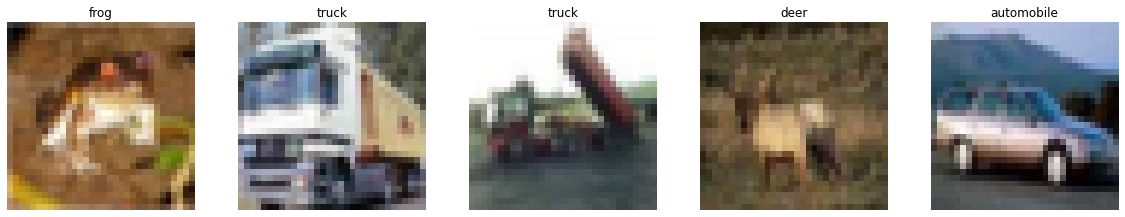

In [4]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')


In [5]:
# Create L2 regularizer
regularizer = regularizers.l2(0.000001)

In [6]:
# Create image data generator
data_gen = ImageDataGenerator(width_shift_range=0.8,height_shift_range=0.8,rotation_range=30,zoom_range=0.1,
shear_range=0.01)
# Get training iterator
iter_train = data_gen.flow(x_train, y_train, batch_size=256)

# Create MobileNetV1 model

This is the MobileNetV1 model, the image shows the architecture. However, some restrictions are used to convert to SNN.

1. No bias tensor should be included in the layers.
2. Avarage polling layers should be used. This is because the concept of maximum output is less meaningful when the only values it can take are zero for n=0 spikes, or one for n>0 spikes.
3. The TF model most consist of ReLU layers.

<img src="https://miro.medium.com/max/856/1*2IHiEn6SYGgz-p80jhYeGg.png" >

In [7]:
print(x_test.shape[1:])
initializer="he_uniform"

(32, 32, 3)


In [13]:
tf_model = models.Sequential([
    layers.Conv2D(filters=96,kernel_size=(11,11), padding='same', activation='relu', use_bias=False,
    kernel_initializer=initializer, kernel_regularizer=regularizer,input_shape=(32,32,3)),
    layers.AveragePooling2D(2),
    layers.Conv2D(filters=256, kernel_size=(5,5),  activation='relu', padding="same", use_bias=False,
    kernel_initializer=initializer, kernel_regularizer=regularizer),
    layers.AveragePooling2D(2),
    layers.Conv2D(filters=384, kernel_size=(3,3),  activation='relu', padding="same", use_bias=False,
    kernel_initializer=initializer, kernel_regularizer=regularizer),
    layers.Conv2D(filters=384, kernel_size=(3,3), activation='relu', padding="same", use_bias=False,
    kernel_initializer=initializer, kernel_regularizer=regularizer),
    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding="same", use_bias=False,
    kernel_initializer=initializer, kernel_regularizer=regularizer),
    layers.AveragePooling2D(2),
    layers.Flatten(),
    layers.Dense(4096, activation='relu', use_bias=False, kernel_regularizer=regularizer),
    layers.Dense(4096, activation='relu', use_bias=False, kernel_regularizer=regularizer),
    layers.Dense(10, activation='softmax', use_bias=False, kernel_regularizer=regularizer)
],name="MobileNetV1")

In [14]:
tf_model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
tf_model.summary()

Model: "alexnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 96)        34848     
_________________________________________________________________
average_pooling2d_5 (Average (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       614400    
_________________________________________________________________
average_pooling2d_6 (Average (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 384)         884736    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 384)         1327104   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 256)         8847

In [16]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True,
                                                 monitor='val_accuracy')

# Train and evaluate TensorFlow model

In [17]:
#train TensorFlow model
steps_per_epoch = x_train.shape[0] // 256
tf_model.fit(iter_train, steps_per_epoch=steps_per_epoch, epochs=200, callbacks=cp_callback, validation_data=(x_test,y_test))

Epoch 1/200
195/195 [==============================] - 34s 164ms/step - loss: 2.6312 - accuracy: 0.1341 - val_loss: 1.9916 - val_accuracy: 0.2785

Epoch 00001: val_accuracy improved from -inf to 0.27850, saving model to training_1/cp.ckpt
Epoch 2/200
195/195 [==============================] - 31s 160ms/step - loss: 2.0793 - accuracy: 0.2254 - val_loss: 1.9012 - val_accuracy: 0.3107

Epoch 00002: val_accuracy improved from 0.27850 to 0.31070, saving model to training_1/cp.ckpt
Epoch 3/200
195/195 [==============================] - 31s 160ms/step - loss: 2.0400 - accuracy: 0.2458 - val_loss: 1.8953 - val_accuracy: 0.3074

Epoch 00003: val_accuracy did not improve from 0.31070
Epoch 4/200
195/195 [==============================] - 31s 160ms/step - loss: 1.9964 - accuracy: 0.2628 - val_loss: 1.8511 - val_accuracy: 0.3098

Epoch 00004: val_accuracy did not improve from 0.31070
Epoch 5/200
195/195 [==============================] - 31s 160ms/step - loss: 1.9694 - accuracy: 0.2768 - val_loss:

In [18]:
#Evaluate TensorFlow model
tf_model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.7986 - accuracy: 0.7759


[0.7985705137252808, 0.7759000062942505]

In [19]:
#Save MobileNetV1_tf_model
models.save_model(tf_model, 'MobileNetV1_tf_model', save_format='h5')

In [ ]:
def initializer(shape, dtype=None):
    stddev = np.sqrt(2.0 / float(shape[0] * shape[1] * shape[3]))
    return tf.random.normal(shape, dtype=dtype, stddev=stddev)
with CustomObjectScope({'initializer': initializer}):
    tf_model = models.load_model('MobileNetV1_tf_model')

In [ ]:
tf_eval_start_time = perf_counter()
tf_model.evaluate(x_test, y_test)
print("TF evaluation:%f" % (perf_counter() - tf_eval_start_time))

157/157 [==============================] - 4s 10ms/step - loss: 2.7079 - accuracy: 0.6964
TF evaluation:5.893035


# Convert MobileNetV1 model to ML GeNN

## Norm method:

- Data Normalization : 'data-norm'
- Spike Normalization : 'spike-norm'
- few spikes: 'FS' 



## Aditional parameters for Data-norm and Spike Norm

Input type:

- Spike input neurons : 'spike'
- Spike input neurons signed : 'spike_signed'
- Poisson input neurons : 'poisson'
- Poisson input neurons signed : 'poisson_signed'
- IF input : 'if'


In [ ]:
#FS
converter = build_converter(x_norm, K=8, norm_time=500)

## Convert and compile ML GeNN model

tf_model  --  TensorFlow model to be converted

connectivity_type  --  type of synapses in GeNN ('procedural','sparse')

compile_kwargs     --  additional arguments to pass through to Model.compile

In [ ]:
# Convert and compile ML GeNN model
mlg_model = Model.convert_tf_model(
        tf_model, converter=converter, connectivity_type='procedural',
        dt=1.0, batch_size=1, rng_seed=0, 
        kernel_profiling=True)

converting Conv2D layer <conv2d>
ignoring Dropout layer <dropout>
deferring AveragePooling2D layer <average_pooling2d>
converting AveragePooling2D -> Conv2D layers <conv2d_1>
deferring AveragePooling2D layer <average_pooling2d_1>
converting AveragePooling2D -> Conv2D layers <conv2d_2>
deferring AveragePooling2D layer <average_pooling2d_2>
converting AveragePooling2D -> Conv2D layers <conv2d_3>
converting Conv2D layer <conv2d_4>
deferring AveragePooling2D layer <average_pooling2d_3>
ignoring Flatten layer <flatten>
converting AveragePooling2D -> Dense layers <dense>
ignoring Dropout layer <dropout_1>
converting Dense layer <dense_1>
ignoring Dropout layer <dropout_2>
converting Dense layer <dense_2>


## Evaluation GeNN Model

### Evalutation

data          --  list of data for each input layer

labels        --  list of labels for each output layer

time          --  sample presentation time (msec)


## Results Convertions

| Type-Converter | Input-Type     | Time  | ANN accuracy | SNN accuracy |
|----------------|----------------|-------|--------------|--------------|
| data-genn      | poisson        | 250ms | 80%          | 66.07%       |
| data-genn      | poisson_signed | 500ms | 80%          | 71.44%       |
| data-genn      | if             | 500ms | 80%          | 67.2%        |
| spike          | -              | 500ms | 80%          | 65.01%       |

In [ ]:
time = 10 if few_spike else 2500
mlg_eval_start_time = perf_counter()
acc, spk_i, spk_t = mlg_model.evaluate([x_test], [y_test], time, save_samples=[])
print("MLG evaluation:%f" % (perf_counter() - mlg_eval_start_time))

In [ ]:
print('Accuracy of VGG16 GeNN model: {}%'.format(acc[0]))

In [ ]:
#ML GeNN model results
neurons = [l.neurons.nrn for l in mlg_model.layers]
raster_plot(spk_i, spk_t, neurons, time=time)